# Setting up and running analysis on batch runs

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install mesa
!{sys.executable} -m pip install seaborn

In [ ]:
import pandas as pd
wolf_batch = pd.read_csv('./seg_model_batch_run_data.csv', index_col=None)
wolf_batch_steps = pd.read_csv('./seg_model_steps_batch_run_data.csv', index_col=None)

### Get a sense of what's happening with your data by doing some digging around:

In [ ]:
# take a peek at the overall structure
wolf_batch.head()

In [ ]:
# take a peek at the overall structure
wolf_batch_steps.head()

### Some thinking about how to work with this and move forward:
We're interested in the relationship between wolves, sheep, and grass. We did a batch run to generate the CSV data (above) that varied the following parameters:

                params = {"grass_regrowth_time": [*range(25,37,5)], 
                        "sheep_gain_from_food": [*range(2,6,1)],
                        "wolf_gain_from_food": [*range(18,28,2)]
                        }

What we will likely want to look at is how these elements come together. We could replicate the plot from a single run, but I don't know how much that will help us progress on answering our question. Instead, we will want to think about creating separate universes where we focus on the variation of one element and how that impacts our findings. 

### Possible research question: How could we think about the relationship between sheep's gain from food and overall sheep population?

In [ ]:
# We need to get it on the basis of sheep on run by sheep gain
# generate dataset with just sheep and transpose
keep = ~wolf_batch_steps.columns.isin(['Sheep Gain', 'Wolf Gain', 'Run Num', "Animal"])
sheep = wolf_batch_steps.loc[wolf_batch_steps["Animal"]=="Sheep", keep ].T
sheep.columns = sheep.iloc[0] #rename columns

sheep

In [ ]:
from wolf_sheep.model import WolfSheep
from mesa.batchrunner import FixedBatchRunner

import json 
import pandas as pd
from itertools import product

# parameters that will remain constant
fixed_parameters = {
    "height": 20,
    "width": 20,
    "initial_sheep": 100,
    "initial_wolves": 50,
    "sheep_reproduce": 0.04,
    "wolf_reproduce": 0.05,
    "grass": True,
}

# parameters you want to vary
# can also include combinations here
params = {"grass_regrowth_time": [*range(25,37,5)], 
        "sheep_gain_from_food": [*range(2,6,1)],
        "wolf_gain_from_food": [*range(18,27,2)]
        }

# combine all the parameters you want to combine using this function
def dict_product(dicts): #could just use the below but it's cleaner this way
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in product(*dicts.values()))

parameters_list = [*dict_product(params)]

# what to run and what to collect
# iterations is how many runs per parameter value
# max_steps is how long to run the model
batch_run = FixedBatchRunner(WolfSheep, parameters_list, 
                            fixed_parameters, iterations=10,
                            model_reporters={
                                "Wolves": lambda m: m.wolves,
                                "Sheep": lambda m: m.sheep,
                                "Grass Growth": lambda m: m.grass_growth,
                            }, 
                                max_steps=50)

# run the batches of your model with the specified variations
batch_run.run_all()





In [ ]:
############################
# get the data and export it! THIS GIVES YOU WIDE DATA
#gather our data (dumps into dictionary)
batch_dict_steps = batch_run.get_collector_model()

# IMPORTANT: Think about how you want to use your data
# We're pulling the items into a dataframe and giving things 'nice' names
batch_dict_steps2 = pd.DataFrame([(key,key1,list(val1)) for key,val in batch_dict_steps.items() for key1,val1 in val.items()])

# get out the parameter values
params = pd.DataFrame(batch_dict_steps2[0].to_list()).rename(columns = {0:"Grass Regrowth", 1:"Sheep Gain", 2:"Wolf Gain", 3: "Run Num"})

# get the animal values
animals = pd.DataFrame(batch_dict_steps2[1].to_list()).rename(columns = {0:"Animal"})

#split the values from each step into a column:
steps = pd.DataFrame(batch_dict_steps2[2].to_list())

#bring the datasets together
batch_dict_steps2 = pd.concat([params, animals, steps], axis = 1)

#dump into a csv
batch_dict_steps2.to_csv("./data/seg_model_steps_batch_run_data_wide.csv", index=False)





In [ ]:
############################
# get the data and export it! THIS GIVES YOU LONG DATA
#bring the datasets together
#batch_dict_steps_long = pd.concat([params, animals, steps], axis = 0)
#batch_dict_steps_long

batch_dict_steps2

### Fun with plots
We want to think about how to best convey our data -- we can think about conveying what we observe overall and then breaking it out by our variables. We can do this based on the different parameters we vary. However, we do want to be mindful that this might just look like a lot of graphs. So, we want to be clear in our labels and to provide context whenever possible. For this setup, the context I'm providing is overall averages and relative averages. 

In [ ]:
batch_long = batch_dict_steps2.melt(id_vars=["Run Num", "Grass Regrowth", "Sheep Gain", "Wolf Gain", "Animal"], value_vars=[*range(0,51)], var_name = "Step Num", value_name="Count")

batch_long

In [ ]:
# first step is to create some averages for our data: overall and then by the various parameters we swept.

# overall averages: (you could go all-out here, but I tried to keep it somewhat simple)
batch_avgs = batch_long.groupby(['Animal', "Step Num"]).mean()
batch_avgs_grass = batch_long.groupby(['Animal', "Grass Regrowth", "Step Num"]).mean()
batch_avgs_wolf = batch_long.groupby(['Animal', "Wolf Gain", "Step Num"]).mean()
batch_avgs_sheep = batch_long.groupby(['Animal', "Sheep Gain", "Step Num"]).mean()
batch_avgs_sweep = batch_long.groupby(['Animal', "Grass Regrowth", "Wolf Gain", "Sheep Gain", "Step Num"]).mean()

batch_avgs


[Text(0.5, 1.0, 'Batch Runs: Animal counts over 50 steps from 600 runs')]

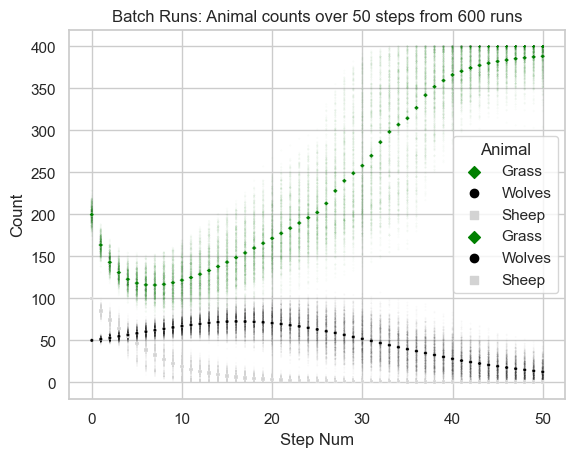

In [164]:
# Scatterplot party!
import seaborn as sns
sns.set_theme(style="whitegrid")



# Do an overall plot to see how things look: 
# Note that the transparency and size are low here -- just want a general sense of the data
sns.scatterplot(x="Step Num", y="Count", hue="Animal",  
                palette=["green", "black", "lightgray"], style= "Animal", 
                s= 2, hue_order=["Grass", "Wolves", "Sheep"],
                markers = {"Grass": "D", "Wolves": "o", "Sheep": "s" }, 
                alpha = 0.02,
             data=batch_long).set(title='Batch Runs: Animal counts over 50 steps from 600 runs')

# Also add in averages for overall
# Note that here we have a larger point size and no transparency
# Need to fix the legend XXX
sns.scatterplot(x="Step Num", y="Count", hue="Animal",  
                palette=["green", "black", "lightgray"], style= "Animal", 
                s= 6, hue_order=["Grass", "Wolves", "Sheep"],
                markers = {"Grass": "D", "Wolves": "o", "Sheep": "s" }, 
             data=batch_avgs).set(title='Batch Runs: Animal counts over 50 steps from 600 runs')


In [163]:
## Compare all averages across all parameter sweeps

[batch_long, batch_avgs, batch_avgs_grass, batch_avgs_sheep, batch_avgs_wolf, batch_avgs_sweep]
batch_avgs_collection = pd.merge(left=batch_long)
batch_long

pd.merge

TypeError: merge() got multiple values for argument 'left'

In [ ]:
sns.set_theme(style="whitegrid")

## Here, we will do something similar to what we did above, but breaking it out by different components
# Look at previous plot but incorporate variables from runs (varying regrowth and gains)
facet_grass = sns.relplot(x="Step Num", y="Count", hue="Animal",  
                palette=["green", "black", "lightgray"], style= "Animal", 
                s= 3, hue_order=["Grass", "Wolves", "Sheep"],
                markers = {"Grass": "D", "Wolves": "o", "Sheep": "s" }, 
                alpha = 0.05, col = "Grass Regrowth",
             data=batch_long, kind = "scatter")

facet_grass.fig.subplots_adjust(top=0.85)

#add overall title
facet_grass.fig.suptitle('Batch Runs: Animal counts over 50 steps from 600 runs')

# Also add in averages for overall
# Note that here we have a larger point size and no transparency
# Need to fix the legend XXX
sns.relplot(x="Step Num", y="Count", hue="Animal",  
                palette=["green", "black", "lightgray"], style= "Animal", 
                s= 6, hue_order=["Grass", "Wolves", "Sheep"],
                markers = {"Grass": "D", "Wolves": "o", "Sheep": "s" }, 
               col = "Grass Regrowth", kind="scatter",
             data=batch_avgs_grass)
sns.relplot(x="Step Num", y="Count", hue="Animal",  
                palette=["green", "black", "lightgray"], style= "Animal", 
                s= 6, hue_order=["Grass", "Wolves", "Sheep"],
                markers = {"Grass": "D", "Wolves": "o", "Sheep": "s" }, 
               col = "Grass Regrowth", kind="scatter",
             data=batch_avgs)

